# Section 1

In this notebook, we prepare plots for Section 1 of the manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML"
df_lin = pd.read_csv(base_p / "df_task_data_linear.tsv", sep="\t")
df_nlin = pd.read_csv(base_p / "df_task_data.tsv", sep='\t')

In [3]:
df_lin.task_type.value_counts()

1v1               310
1v9               252
high_vs_95low      90
high_vs_looser     90
Name: task_type, dtype: int64

In [4]:
df_lin.seed_id.value_counts()

0    375
2    139
1    139
3     89
Name: seed_id, dtype: int64

In [5]:
df_lin.split_id.value_counts()

0    742
Name: split_id, dtype: int64

In [6]:
df_nlin.task_type.value_counts()

1v1               900
1v9               100
high_vs_looser    100
high_vs_95low     100
Name: task_type, dtype: int64

In [7]:
df_lin.ag_pos.value_counts()

3RAJ         45
5E94         45
1NSN         45
3VRL         45
1H0D         40
3VRL_high    36
3RAJ_high    36
1NSN_high    36
1WEJ_high    36
1ADQ         36
1WEJ         36
1FBI         36
2YPV         36
1OB1         36
1OB1_high    35
5E94_high    34
1FBI_high    34
1H0D_high    34
2YPV_high    34
1ADQ_high    27
Name: ag_pos, dtype: int64

In [8]:
df_nlin.ag_pos.value_counts()

1OB1         100
1FBI         100
1ADQ         100
1WEJ         100
1H0D         100
3RAJ         100
5E94         100
3VRL         100
1NSN         100
2YPV         100
1NSN_high     20
5E94_high     20
2YPV_high     20
1FBI_high     20
3VRL_high     20
3RAJ_high     20
1OB1_high     20
1H0D_high     20
1WEJ_high     20
1ADQ_high     20
Name: ag_pos, dtype: int64

Merging the linear and non_linear for comparison.

In [15]:
df_nlin = df_nlin.groupby(by=["seed_id", "split_id", "task_type", "ag_pos", "ag_neg"])["acc_closed"].mean().reset_index()
df_nlin["model_type"] = "SN10"
df_nlin.to_csv(base_p / "df_task_data_processed.tsv", sep='\t', index=False)

In [10]:
df_lin = df_lin.groupby(by=["seed_id", "split_id", "task_type", "ag_pos", "ag_neg"])["acc_closed"].mean().reset_index()
df_lin["model_type"] = "Linear"

In [11]:
df = pd.merge(
    df_lin,
    df_nlin,
    on=["seed_id", "split_id", "task_type", "ag_pos", "ag_neg"],
    how="inner",
    suffixes=("_lin", "_nlin"),
)
df.shape

(430, 9)

In [12]:
df

,seed_id,split_id,task_type,ag_pos,ag_neg,acc_closed_lin,model_type_lin,acc_closed_nlin,model_type_nlin
0,0,0,1v1,1ADQ,1FBI,0.9542,Linear,0.977471,SN10
1,0,0,1v1,1ADQ,1H0D,0.8837,Linear,0.974257,SN10
2,0,0,1v1,1ADQ,1NSN,0.8881,Linear,0.973757,SN10
3,0,0,1v1,1ADQ,1OB1,0.9196,Linear,0.976157,SN10
4,0,0,1v1,1ADQ,1WEJ,0.9026,Linear,0.967686,SN10
...,...,...,...,...,...,...,...,...,...
425,3,0,high_vs_looser,1WEJ_high,1WEJ_looser,0.7940,Linear,0.908600,SN10
426,3,0,high_vs_looser,2YPV_high,2YPV_looser,0.8633,Linear,0.927700,SN10
427,3,0,high_vs_looser,3RAJ_high,3RAJ_looser,0.7940,Linear,0.877200,SN10
428,3,0,high_vs_looser,3VRL_high,3VRL_looser,0.8922,Linear,0.939000,SN10


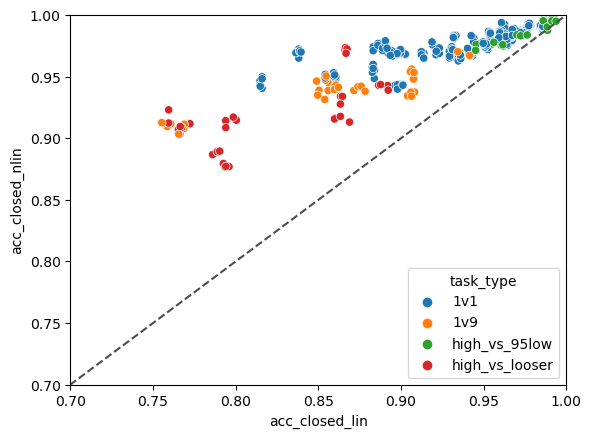

In [13]:
sns.scatterplot(
    data=df,
    x="acc_closed_lin",
    y="acc_closed_nlin",
    hue="task_type",
)
# Fixed axis from 0.7 to 1.0 for better comparison
plt.xlim(0.7, 1.0)
plt.ylim(0.7, 1.0)
# Diagonal line
plt.plot([0, 1], [0, 1], ls="--", c=".3")

<AxesSubplot: xlabel='acc_closed_lin', ylabel='diff'>

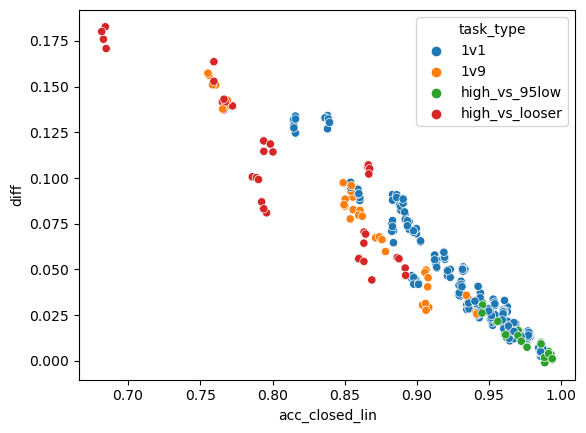

In [14]:
df["diff"] = df["acc_closed_nlin"] - df["acc_closed_lin"]

# Plot diff
sns.scatterplot(
    data=df,
    x="acc_closed_lin",
    y="diff",
    hue="task_type",
)